## Training U-Net for Image Segmentation

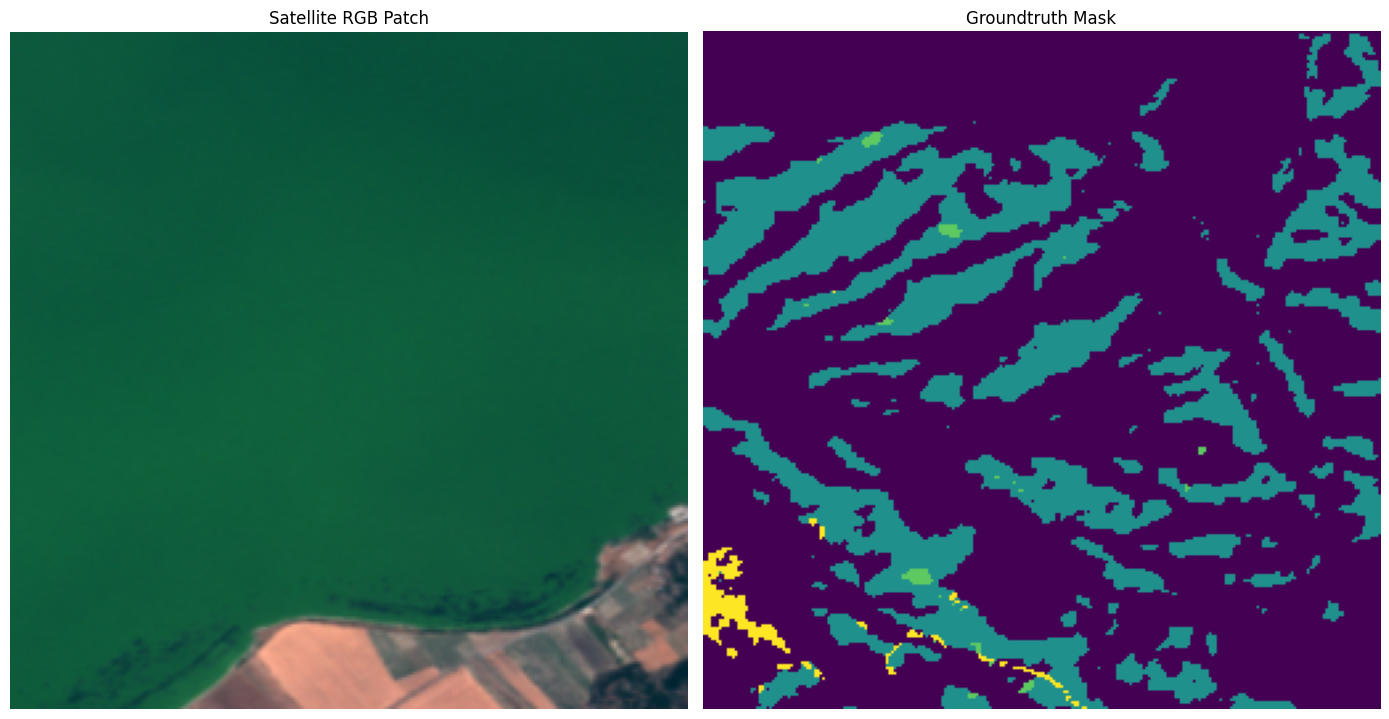

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
pred = np.load(
    "/home/ubuntu/bdrs_ex_1/data/test_patches/images/patch_0463.npy"
)  # shape: (bands, H, W)
gt = np.load(
    "/home/ubuntu/bdrs_ex_1/data/patches/masks/patch_0944_mask.npy"
)  # shape: (H, W)

# Select 3 bands to form RGB (adjust indices as needed)
# For Sentinel-2, common RGB bands: B04 (red), B03 (green), B02 (blue)
rgb = np.stack(
    [
        pred[3],  # Red (B04)
        pred[2],  # Green (B03)
        pred[1],  # Blue (B02)
    ],
    axis=-1,
)

# Normalize the RGB image for display (0-1 range)
rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].imshow(rgb_norm)
ax[0].set_title("Satellite RGB Patch")
ax[0].axis("off")

ax[1].imshow(gt)  # Use colormap for categorical masks
ax[1].set_title("Groundtruth Mask")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [20]:
import utils.utils as utils
import torch
from torch.utils.data import DataLoader
import utils.load_dataset as loader
import numpy as np
from collections import Counter
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
import random

## Loading Dataset

In [2]:
dataset = loader.SatelliteDataset(
    image_dir="data/patches/images", mask_dir="data/patches/masks"
)

## Data Preprocessing

### Data Exploration
Counting Samples for each class

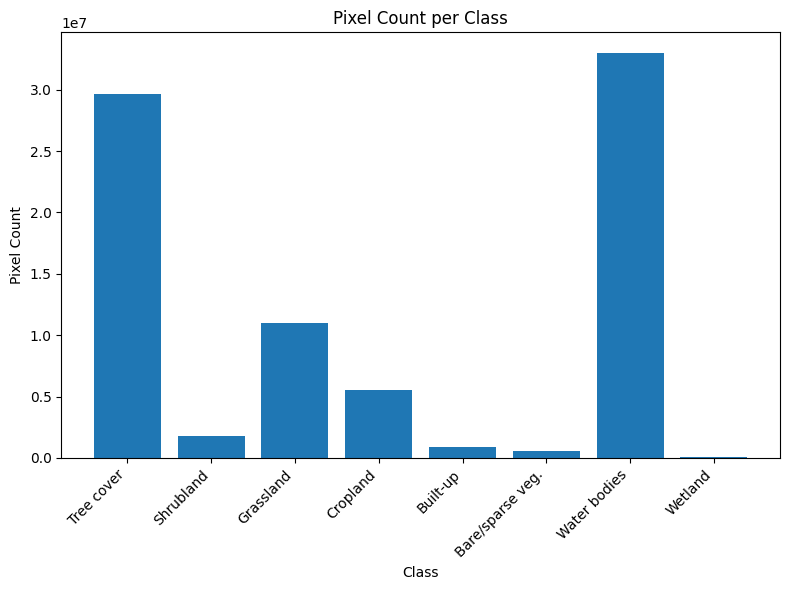

In [3]:
pixel_class_counts = Counter()
for i in range(len(dataset)):
    _, mask = dataset[i]

    if hasattr(mask, "numpy"):
        mask = mask.numpy()
    class_counts = Counter(mask.flatten())
    pixel_class_counts.update(class_counts)

class_names = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/sparse veg.",
    70: "Snow and ice",
    80: "Water bodies",
    90: "Wetland",
    95: "Mangroves",
    100: "Moss/lichen",
}

# Create lists for plotting
classes = sorted(pixel_class_counts.keys())
counts = [pixel_class_counts[c] for c in classes]
labels = [class_names.get(c, f"Class {c}") for c in classes]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts)
plt.title("Pixel Count per Class")
plt.xlabel("Class")
plt.ylabel("Pixel Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

Clean dataset from NaN values

In [16]:
valid = []
for i in range(len(dataset)):
    image, mask = dataset[i]
    if not (image == -9999).any().item():
        valid.append(i)

print("Initial size of dataset:", len(dataset))
clean_dataset = Subset(dataset, valid)
print("size of cleaned dataset:", len(clean_dataset))

Initial size of dataset: 1257
size of cleaned dataset: 1256


Split dataset to Train and Validation using Stratified Sampling

In [31]:
indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)
ds_train = Subset(dataset, train_indices)
ds_val = Subset(dataset, val_indices)

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=32, shuffle=False)

In [32]:
# iter function to load batches
x_train, y_train = next(iter(train_loader))
x_val, y_val = next(iter(val_loader))

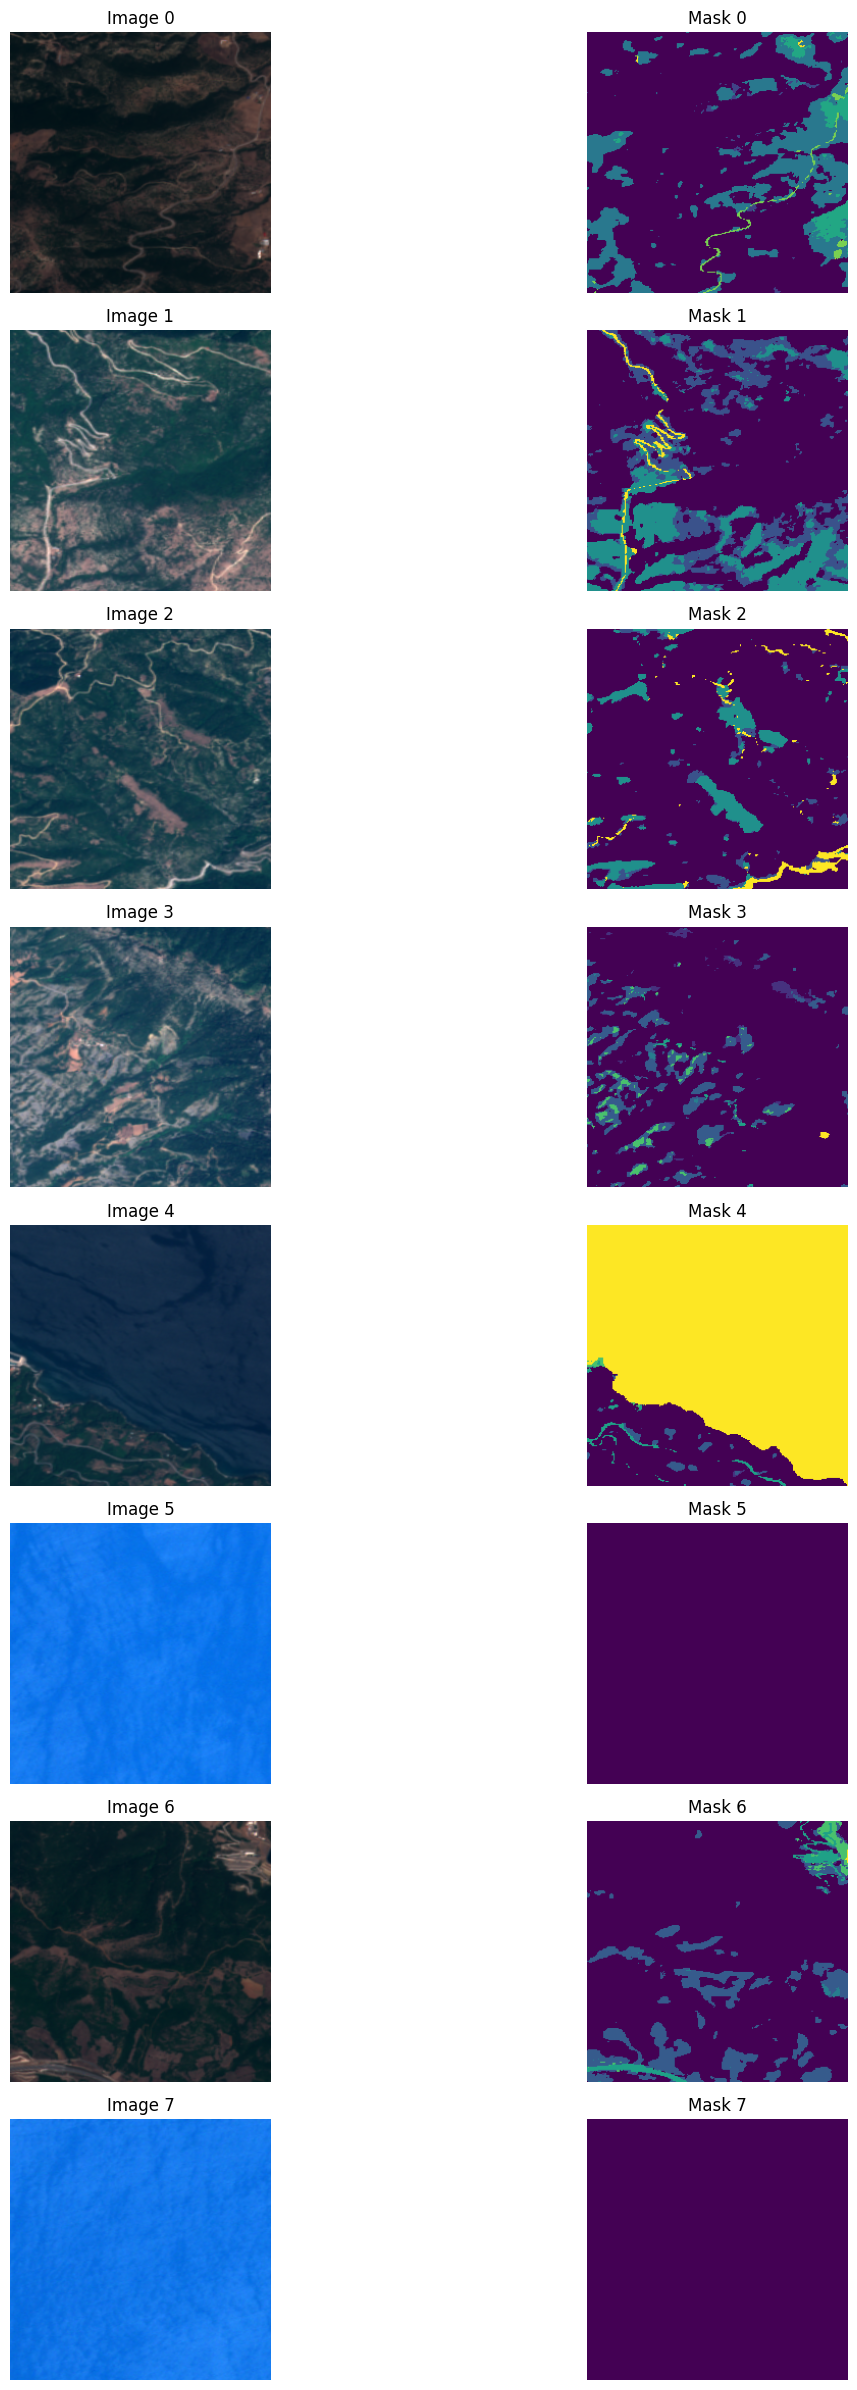

In [ ]:
import matplotlib.pyplot as plt


def visualize_batch(x_batch, y_batch=None, bands=(3, 2, 1), max_images=8):
    """
    Visualize a batch of multi-band images using selected RGB bands.

    Args:
        x_batch: Tensor of shape (B, C, H, W)
        y_batch: Optional masks of shape (B, H, W)
        bands: Tuple of band indices to visualize as RGB
        max_images: Number of images to show
    """
    batch_size = min(x_batch.shape[0], max_images)
    plt.figure(figsize=(15, 3 * batch_size))

    for i in range(batch_size):
        rgb = x_batch[i][list(bands), :, :].detach().cpu()
        rgb = rgb.permute(1, 2, 0)
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

        plt.subplot(batch_size, 2, 2 * i + 1)
        plt.imshow(rgb)
        plt.axis("off")
        plt.title(f"Image {i}")

        if y_batch is not None:
            plt.subplot(batch_size, 2, 2 * i + 2)
            plt.imshow(y_batch[i].cpu())
            plt.axis("off")
            plt.title(f"Mask {i}")

    plt.tight_layout()
    plt.show()


visualize_batch(x_train, y_train)

### Normalization 

In [34]:
def compute_band_stats(dataset):
    sum_per_band = 0
    sum_sq_per_band = 0
    total_pixels = 0

    for images, _ in dataset:
        images = images / 10000.0

        b, c, h, w = images.shape
        pixels = b * h * w
        total_pixels += pixels

        sum_per_band += images.sum(dim=[0, 2, 3])
        sum_sq_per_band += (images**2).sum(dim=[0, 2, 3])

    mean = sum_per_band / total_pixels
    std = (sum_sq_per_band / total_pixels - mean**2).sqrt()

    return mean, std


# mean and std per band
mean_train, std_train = compute_band_stats(train_loader)
mean_val, std_val = compute_band_stats(val_loader)

In [35]:
# scale
x_train = x_train / 10000.0
x_val = x_val / 10000.0

# standart normalization
x_train = (x_train - mean_train[:, None, None]) / std_train[:, None, None]
x_val = (x_val - mean_val[:, None, None]) / std_val[:, None, None]

### Data Augmentation

In [36]:
def add_gaussian_noise(x, mean=0.0, std=0.03):
    noise = torch.randn_like(x) * std + mean
    return x + noise


def apply_augmentation(x, y):
    # Geometric: horizontal flip
    if random.random() < 0.5:
        x = torch.flip(x, dims=[2])
        y = torch.flip(y, dims=[1])

    # Radiometric: Gaussian noise
    x = add_gaussian_noise(x, std=0.02)
    return x, y


x_train, y_train = apply_augmentation(x_train, y_train)

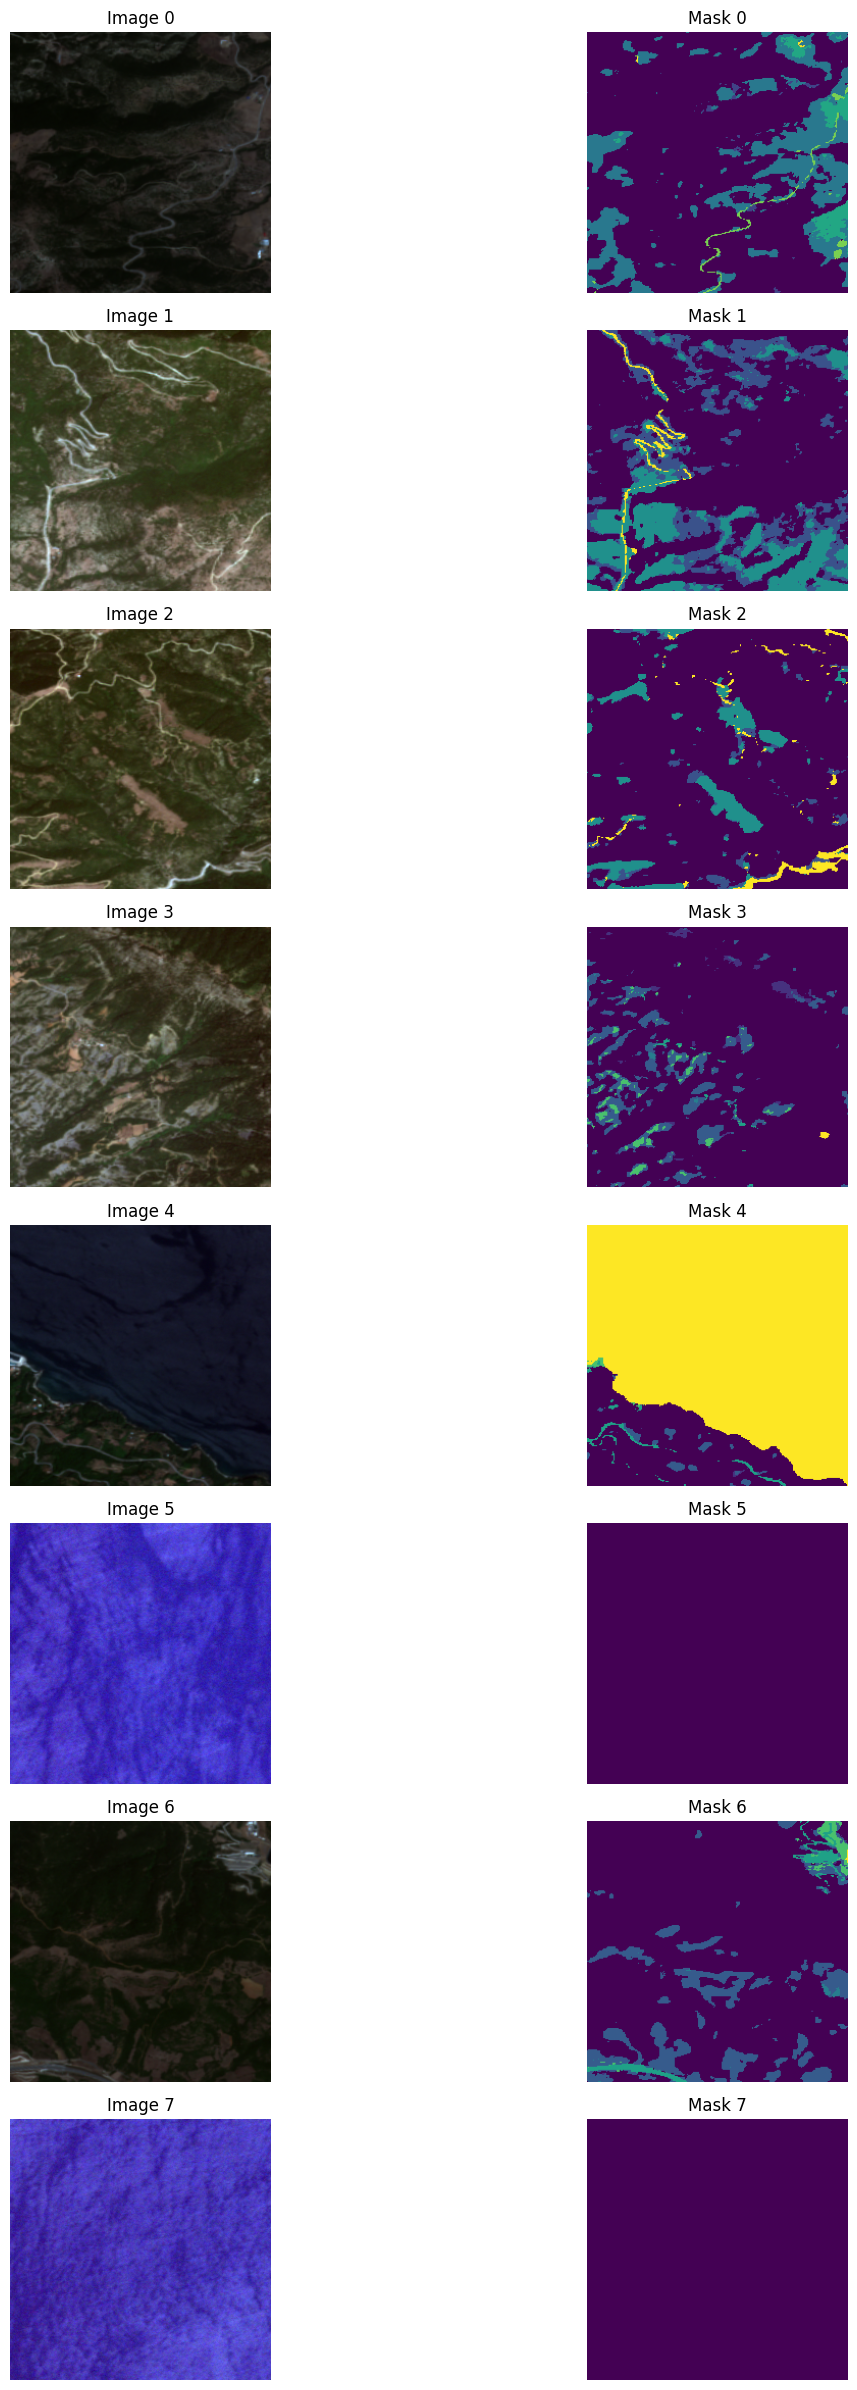

In [ ]:
visualize_batch(x_train, y_train)